# San Diego Burrito Analytics: Data characterization

Scott Cole

21 May 2016

This notebook characterizes the collection of reviewers of San Diego burritos including:

1. Metadata
2. How many of each kind of burrito have been reviewed?
3. For each of burrito dimension, what is the distribution of its scores across all samples?

### Default imports

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
sns.set_style("white")

### Load data

In [2]:
import util
df = util.load_burritos()
N = df.shape[0]

### Brief metadata

In [3]:
print 'Number of burritos:', df.shape[0]
print 'Number of restaurants:', len(df.Location.unique())
print 'Number of reviewers:', len(df.Reviewer.unique())
print 'Number of reviews by Scott:', df.Reviewer.value_counts()['Scott']
print 'Number of reviews by Emily:', df.Reviewer.value_counts()['Emily']

uniqlocidx = df.Location.drop_duplicates().index
print 'Percentage of taco shops with free chips:', np.round(100 - 100*df.Chips[uniqlocidx].isnull().sum()/np.float(len(df.Location.unique())),1)

Number of burritos: 275
Number of restaurants: 71
Number of reviewers: 59
Number of reviews by Scott: 97
Number of reviews by Emily: 43
Percentage of taco shops with free chips: 25.4


In [4]:
# Count of how many burritos each person has eaten
df['Reviewer'].value_counts()

Scott           97
Emily           43
Ricardo         14
Sage            12
Elynn            8
Luis             8
Brent            8
Erin             6
Richard          6
Matteo           4
Marc             4
Bankole          3
Hannah           3
Tom              3
Erik             2
Devleena         2
Shijia           2
Aga              2
Kelsey           2
Tara             2
Katie            2
Cris             2
Sankha G         2
Jeremy           2
Mike             2
Christian        1
Torben           1
Andy             1
Jake             1
Ant              1
Rob G            1
Ashley G         1
Melissa G        1
Melissa N        1
Eli              1
Dan              1
Tammy            1
Leo              1
@synapticlee     1
Alejandro        1
Daniel           1
Aaron S          1
Rob              1
Sam A            1
Shreejoy         1
Sam H            1
Brad P           1
Brad             1
@danjlurie       1
Benni            1
Meghan           1
Alex             1
Javier      

### What types of burritos have been rated?

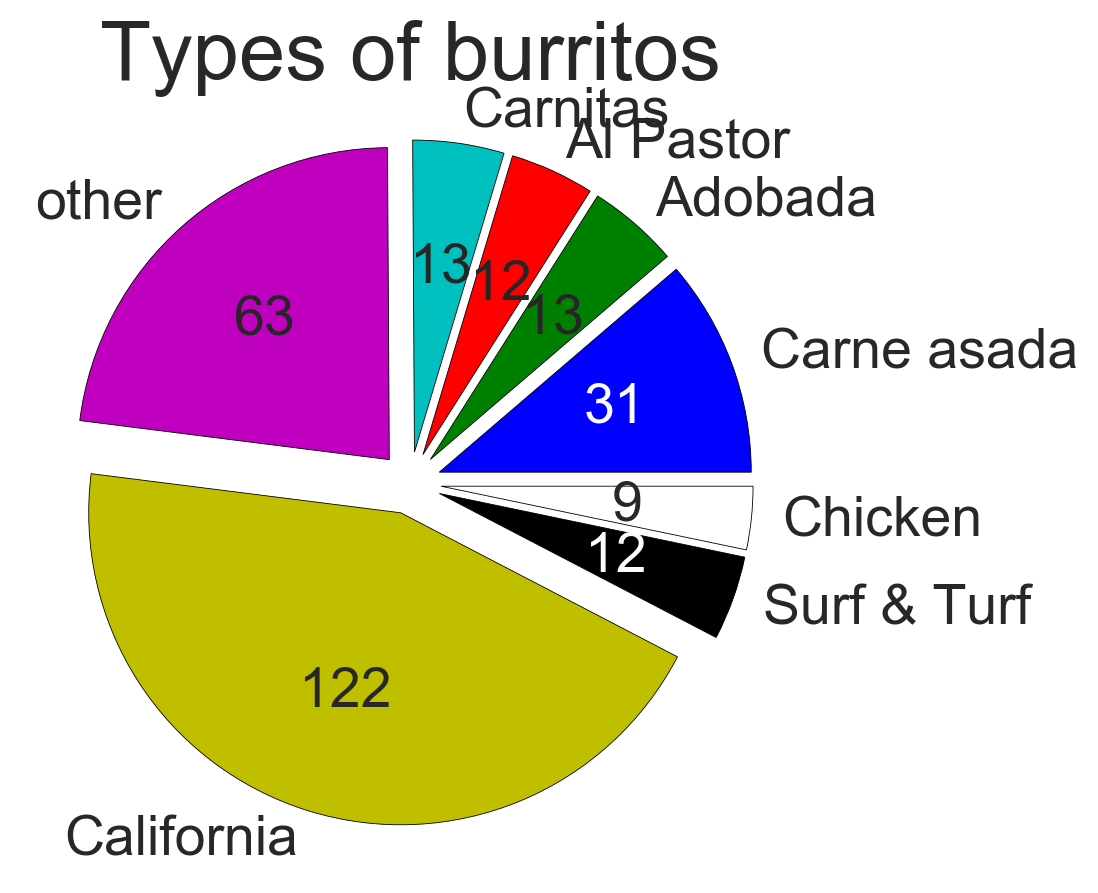

In [5]:
# Number of each type of burrito
def burritotypes(x, types = {'California':'cali', 'Carnitas':'carnita', 'Carne asada':'carne asada',
                             'Chicken':'chicken', 'Surf & Turf':'surf.*turf', 'Adobada':'adobad', 'Al Pastor':'pastor'}):
    import re
    T = len(types)
    Nmatches = {}
    for b in x:
        matched = False
        for t in types.keys():
            re4str = re.compile('.*'+types[t]+'.*', re.IGNORECASE)
            if np.logical_and(re4str.match(b) is not None, matched is False):
                try:
                    Nmatches[t] +=1
                except KeyError:
                    Nmatches[t] = 1
                matched = True
        if matched is False:
            try:
                Nmatches['other'] +=1
            except KeyError:
                Nmatches['other'] = 1
    return Nmatches

typecounts = burritotypes(df.Burrito)

plt.figure(figsize=(6,6))
ax = plt.axes([0.1, 0.1, 0.65, 0.65])

# The slices will be ordered and plotted counter-clockwise.
labels = typecounts.keys()
fracs = typecounts.values()
explode=[.1]*len(typecounts)

patches, texts, autotexts = plt.pie(fracs, explode=explode, labels=labels,
                autopct=lambda(p): '{:.0f}'.format(p * np.sum(fracs) / 100), shadow=False, startangle=0)
                # The default startangle is 0, which would start
                # the Frogs slice on the x-axis.  With startangle=90,
                # everything is rotated counter-clockwise by 90 degrees,
                # so the plotting starts on the positive y-axis.

plt.title('Types of burritos',size=30)
for t in texts:
    t.set_size(20)
for t in autotexts:
    t.set_size(20)
autotexts[0].set_color('w')
autotexts[6].set_color('w')

figname = 'burritotypes'
plt.savefig('C:/gh/fig/burrito/'+figname + '.png')

### Progress in number of burritos rated

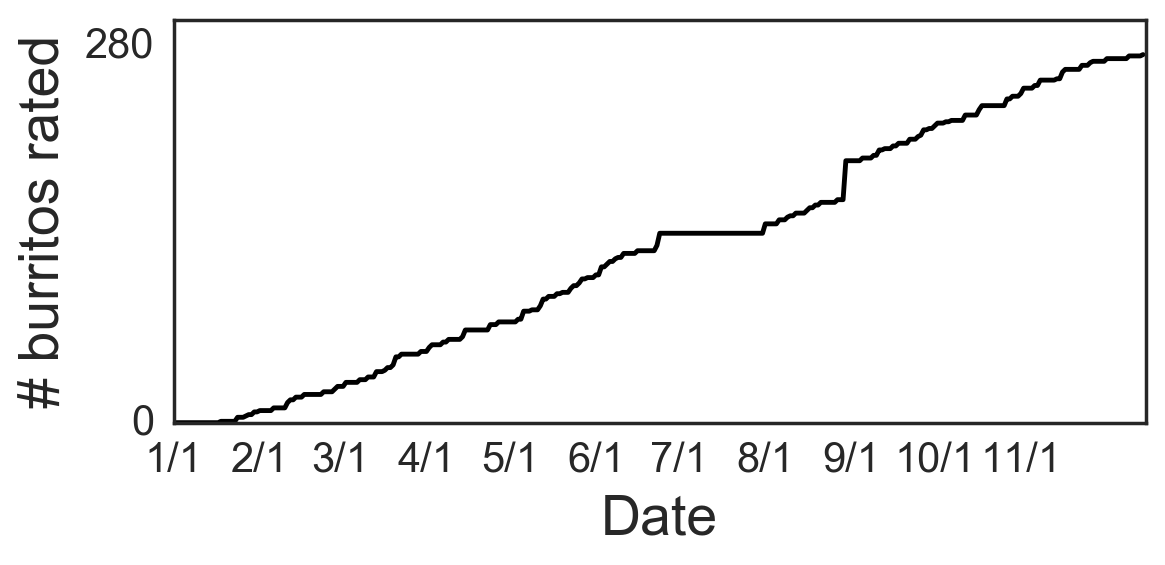

In [6]:
# Time series of ratings
import math

def dates2ts(dates):
    from datetime import datetime
    
    D = len(dates)
    start = datetime.strptime('1/1/2016','%m/%d/%Y')
    ts = np.zeros(D,dtype=int)
    for d in range(D):
        burrdate = datetime.strptime(df.Date[d],'%m/%d/%Y')
        diff = burrdate - start
        ts[d] = diff.days
    return ts

def cumburritos(days):
    from statsmodels.distributions.empirical_distribution import ECDF
    ecdf = ECDF(days)
    t = np.arange(days[-1]+1)
    return t, ecdf(t)*len(days)

def datelabels(startdate = '1/1/2016', M = 11):
    from datetime import datetime
    start = datetime.strptime(startdate,'%m/%d/%Y')
    datestrs = []
    ts = np.zeros(M)
    for m in range(M):
        datestrs.append(str(m+1) + '/1')
        burrdate = datetime.strptime(datestrs[m]+'/2016','%m/%d/%Y')
        diff = burrdate - start
        ts[m] = diff.days
    return datestrs, ts

burrdays = dates2ts(df.Date)
t, burrcdf = cumburritos(burrdays)
datestrs, datets = datelabels()

plt.figure(figsize=(6,3))
plt.plot(t,burrcdf,'k-')
plt.xlabel('Date',size=20)
plt.ylabel('# burritos rated',size=20)
plt.xticks(datets,datestrs,size=15)
plt.yticks((0,int(math.ceil(len(burrdays) / 10.0)) * 10),size=15)
plt.tight_layout()

figname = 'burritoprogress'
plt.savefig('C:/Users/Scott/Google Drive/qwm/burritos/figs/'+figname + '.png')

# Burrito dimension distributions

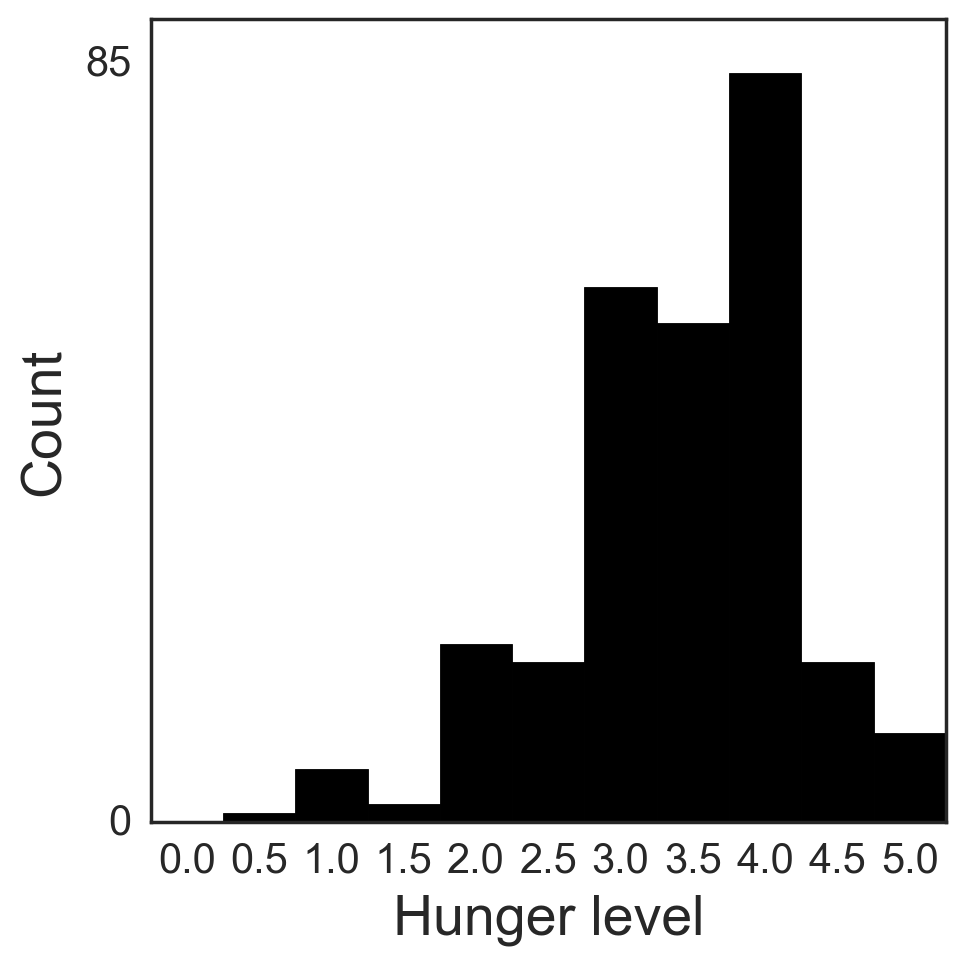

In [7]:
# Distribution of hunger level
plt.figure(figsize=(5,5))
n, _, _ = plt.hist(df.Hunger,np.arange(-.25,5.5,.5),color='k')
plt.xlabel('Hunger level',size=20)
plt.xticks(np.arange(0,5.5,.5),size=15)
plt.xlim((-.25,5.25))
plt.ylabel('Count',size=20)
plt.yticks((0,int(math.ceil(np.max(n) / 5.)) * 5),size=15)
plt.tight_layout()

figname = 'hungerleveldist'
plt.savefig('C:/gh/fig/burrito/'+figname + '.png')

6.84557195572


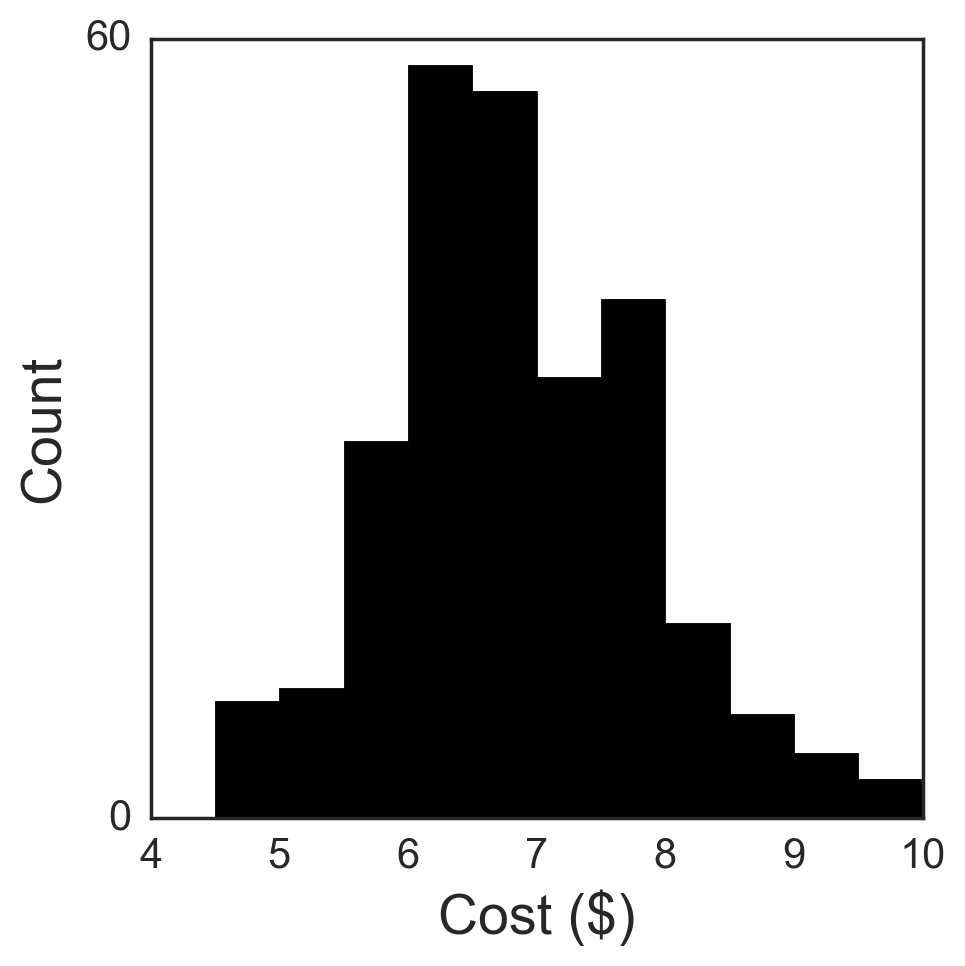

In [10]:
# Average burrito cost
plt.figure(figsize=(5,5))
n, _, _ = plt.hist(df.Cost.dropna(),np.arange(4,10.25,.5),color='k')
plt.xlabel('Cost ($)',size=20)
plt.xticks(np.arange(4,11,1),size=15)
plt.xlim((4,10))
plt.ylabel('Count',size=20)
plt.yticks((0,int(math.ceil(np.max(n) / 5.)) * 5),size=15)
plt.tight_layout()

figname = 'costdist'
plt.savefig('C:/gh/fig/burrito/'+figname + '.png')

print np.nanmean(df.Cost)

0.769289940828


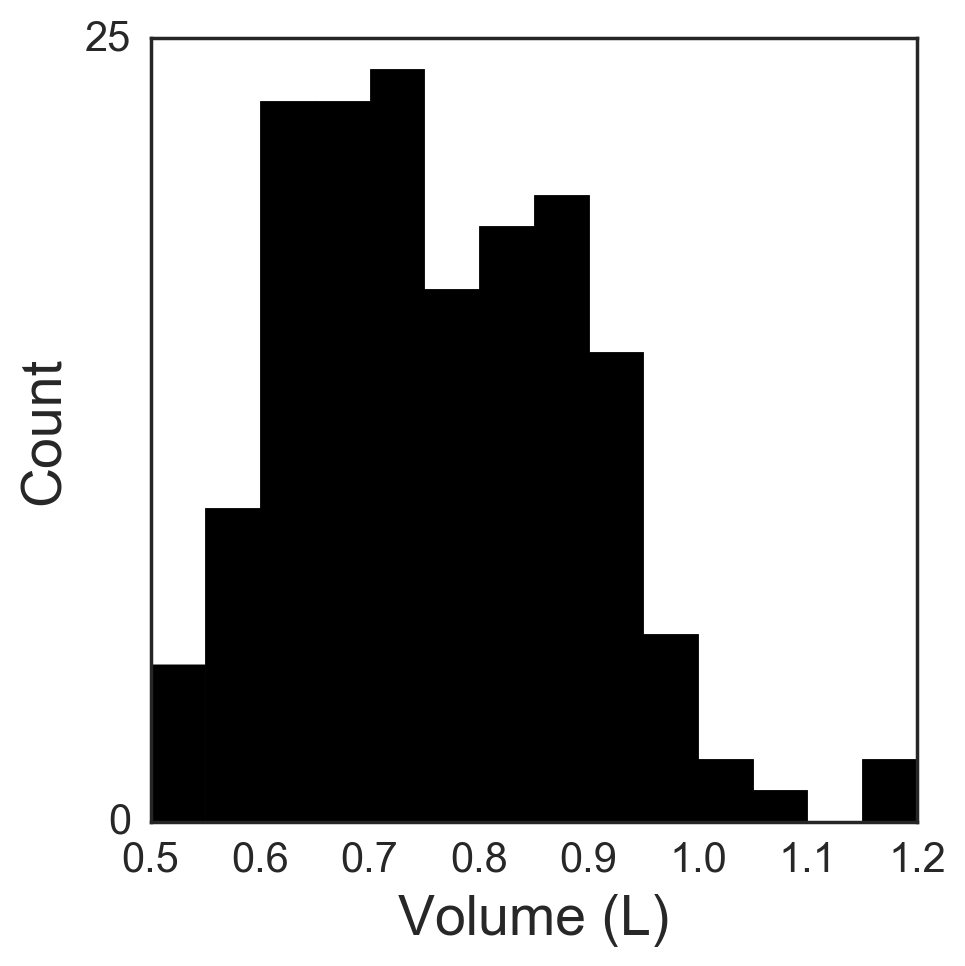

In [11]:
# Volume dist
plt.figure(figsize=(5,5))
n, _, _ = plt.hist(df.Volume.dropna(),np.arange(0.5,1.3,.05),color='k')
plt.xlabel('Volume (L)',size=20)
plt.xticks(np.arange(0.5,1.3,.1),size=15)
plt.xlim((0.5,1.2))
plt.ylabel('Count',size=20)
plt.yticks((0,int(math.ceil(np.max(n) / 5.)) * 5),size=15)
plt.tight_layout()

figname = 'volumedist'
plt.savefig('C:/gh/fig/burrito/'+figname + '.png')

print np.mean(df.Volume)

In [12]:
def metrichist(metricname):
    plt.figure(figsize=(5,5))
    n, _, _ = plt.hist(df[metricname].dropna(),np.arange(-.25,5.5,.5),color='k')
    plt.xlabel(metricname + ' rating',size=20)
    plt.xticks(np.arange(0,5.5,.5),size=15)
    plt.xlim((-.25,5.25))
    plt.ylabel('Count',size=20)
    plt.yticks((0,int(math.ceil(np.max(n) / 5.)) * 5),size=15)
    plt.tight_layout()
    
    if metricname == 'Meat:filling':
        metricname = 'meattofilling'
    figname = metricname + 'dist'
    plt.savefig('C:/gh/fig/burrito/'+figname + '.png')

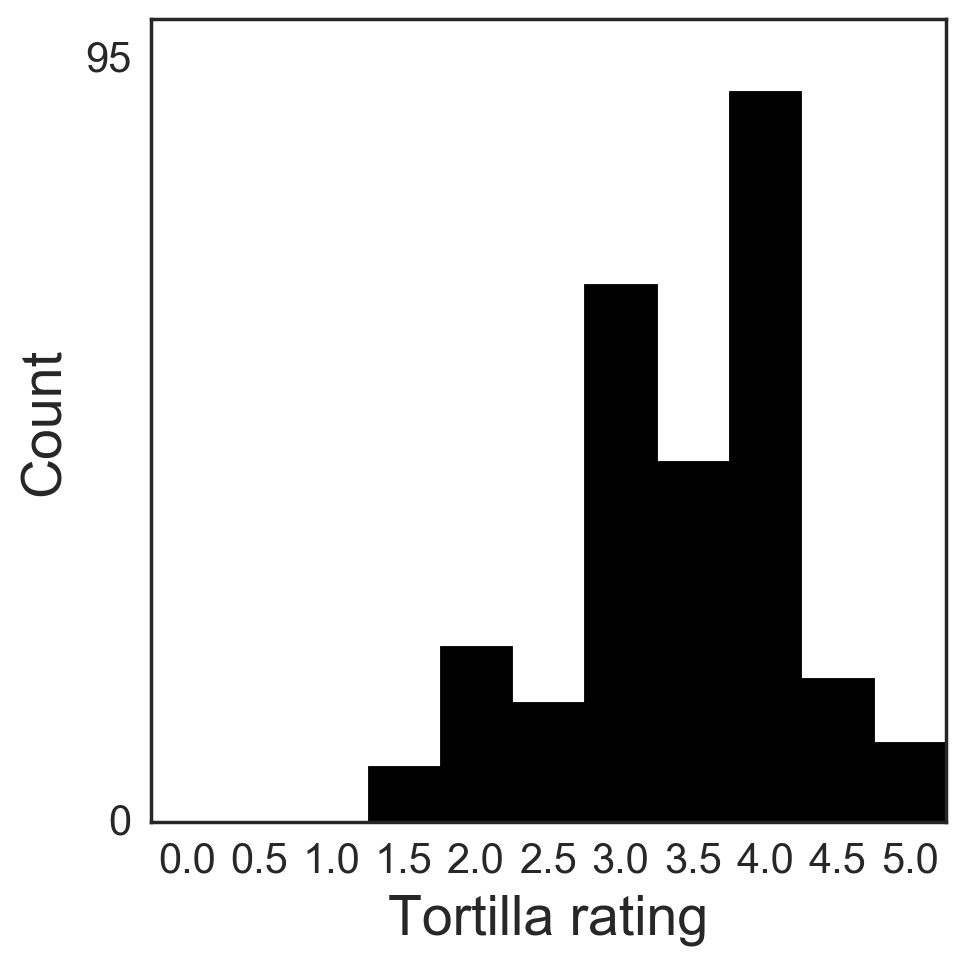

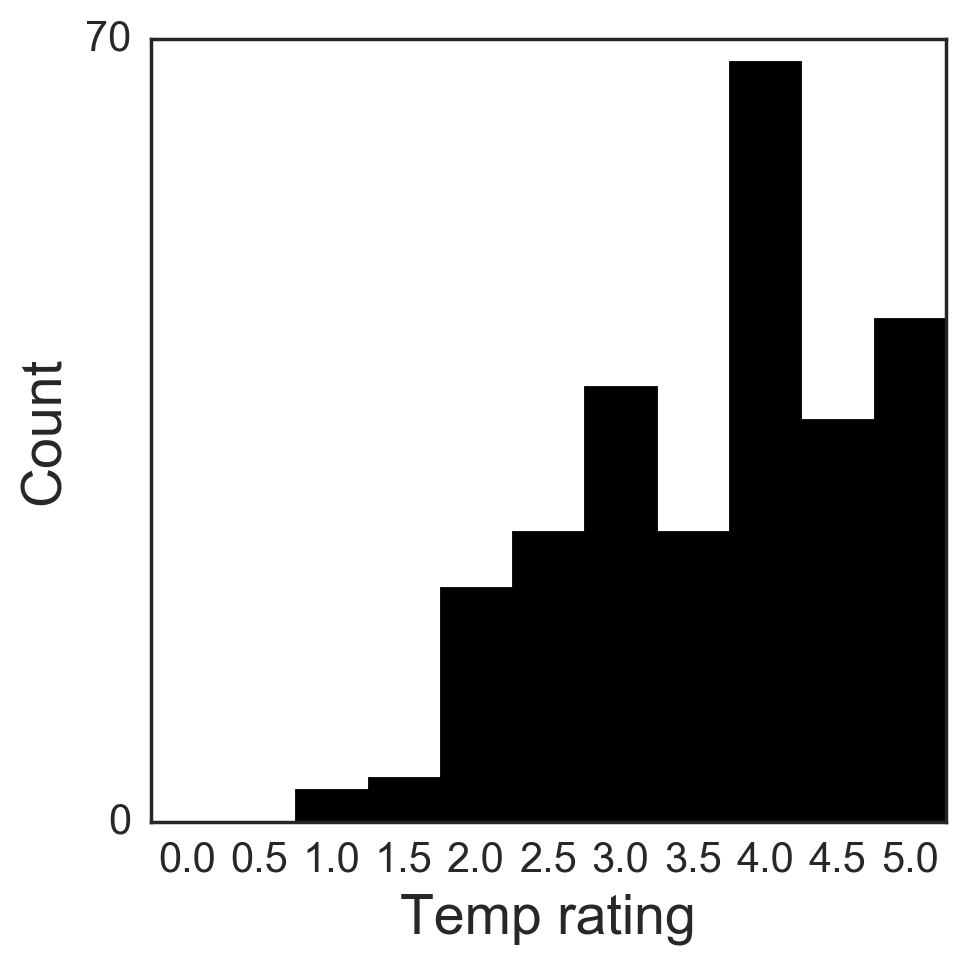

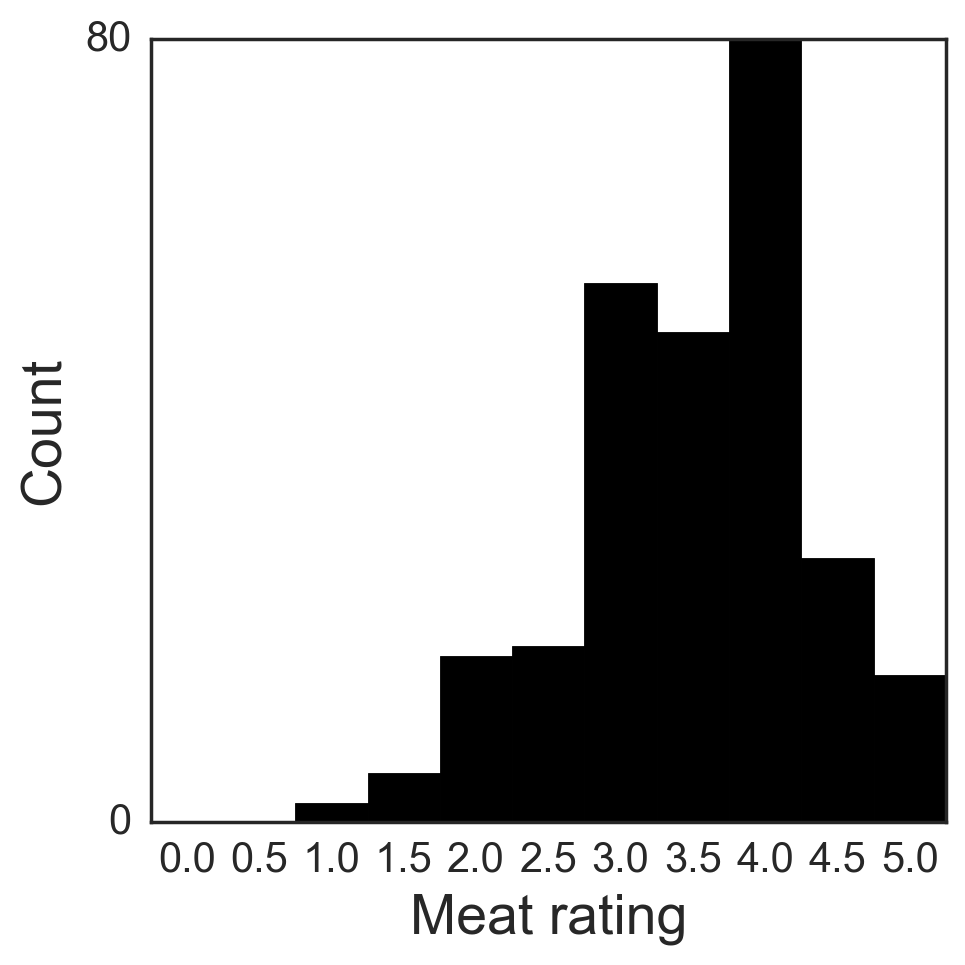

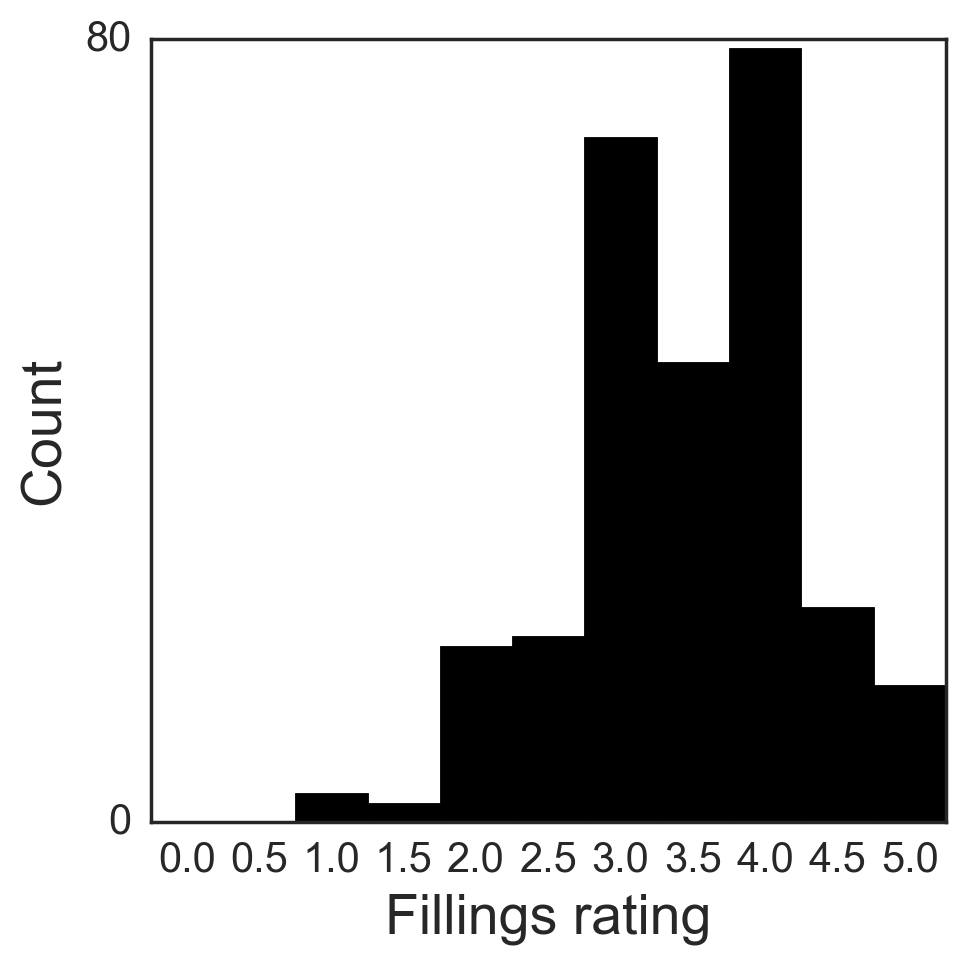

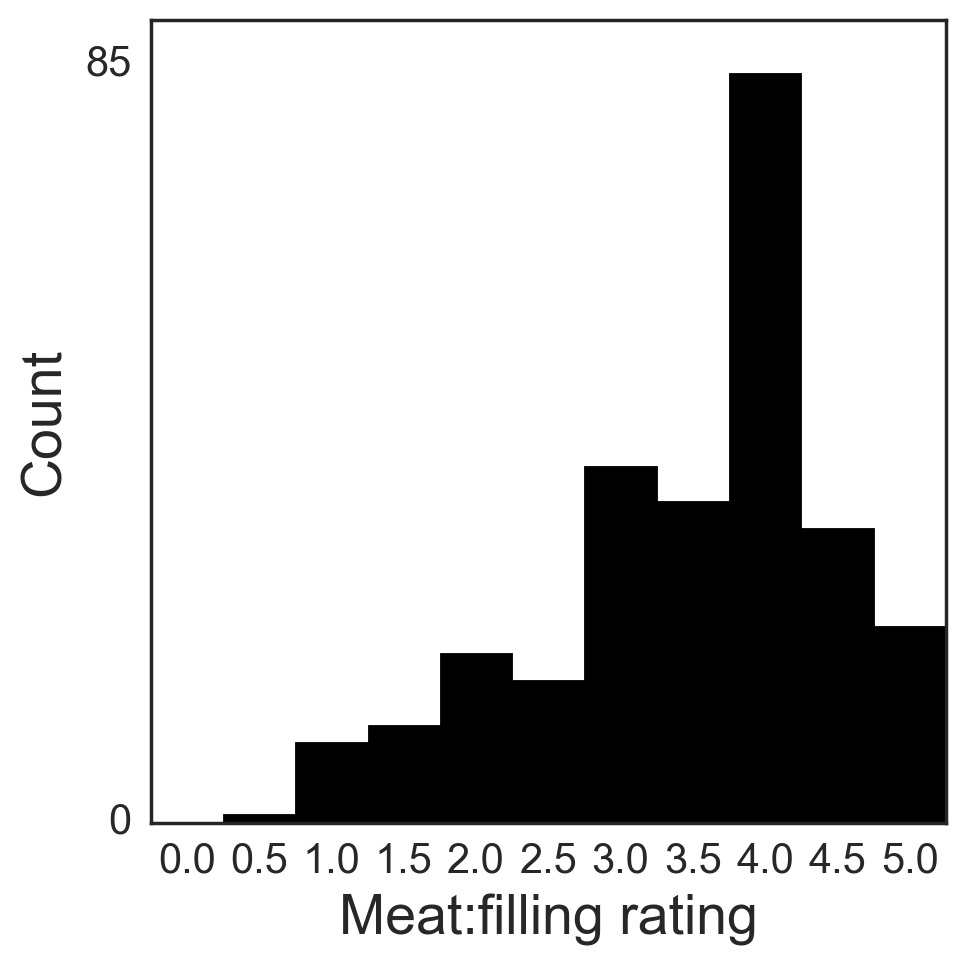

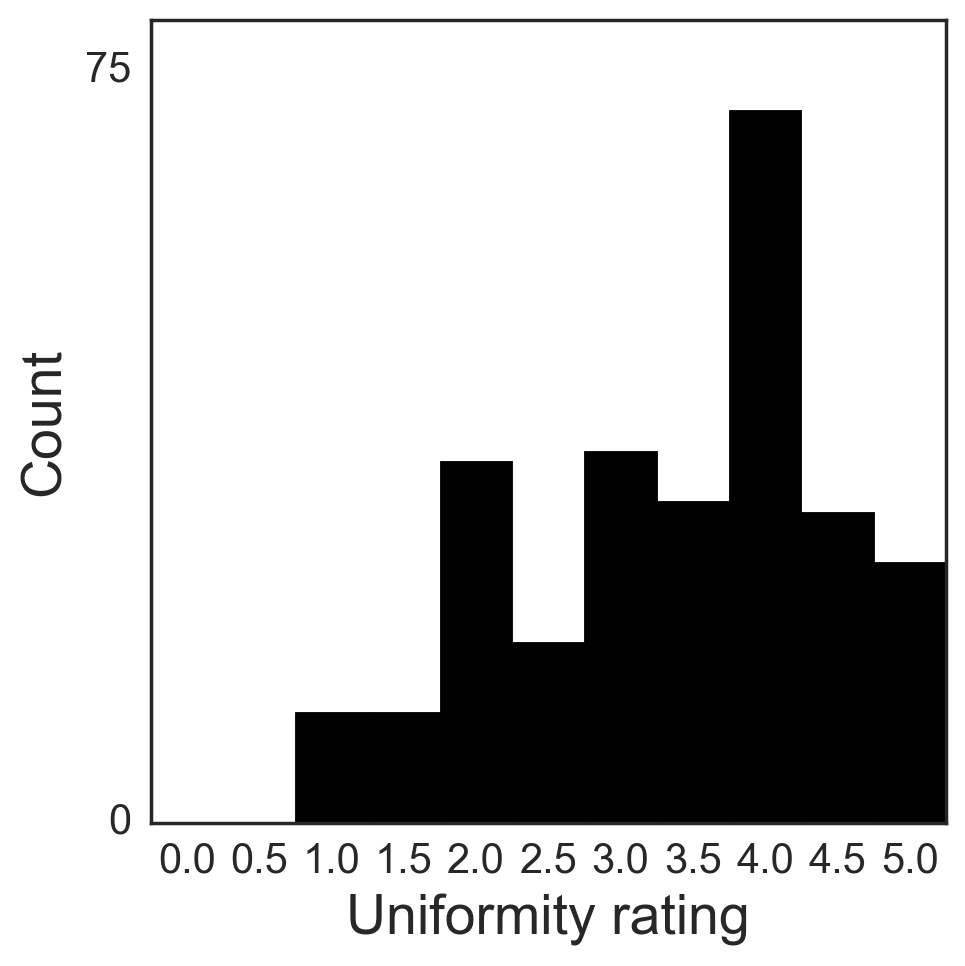

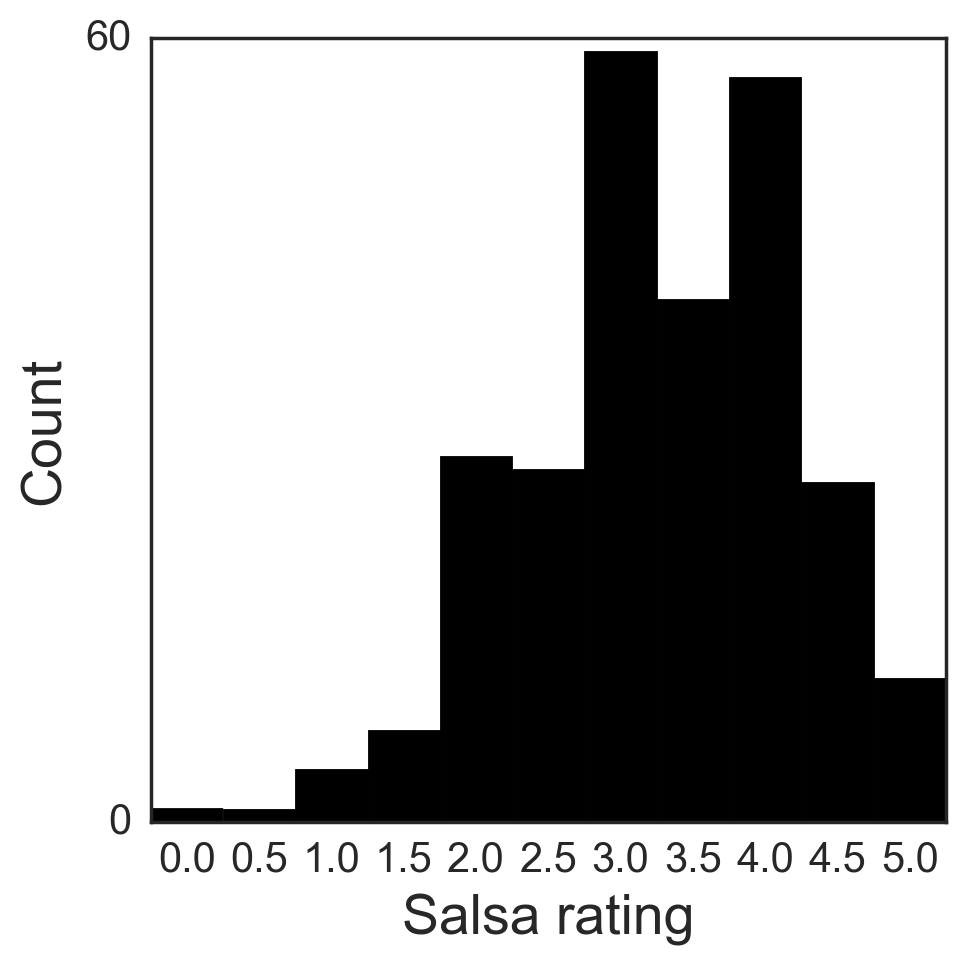

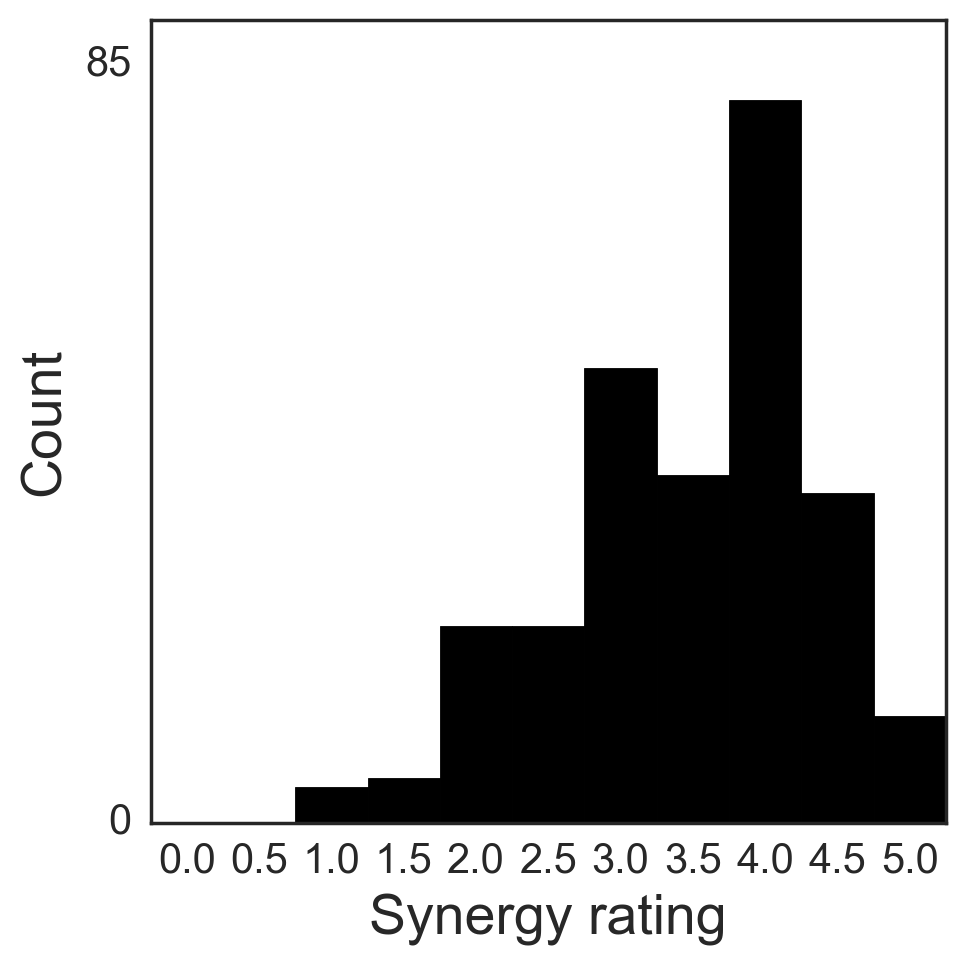

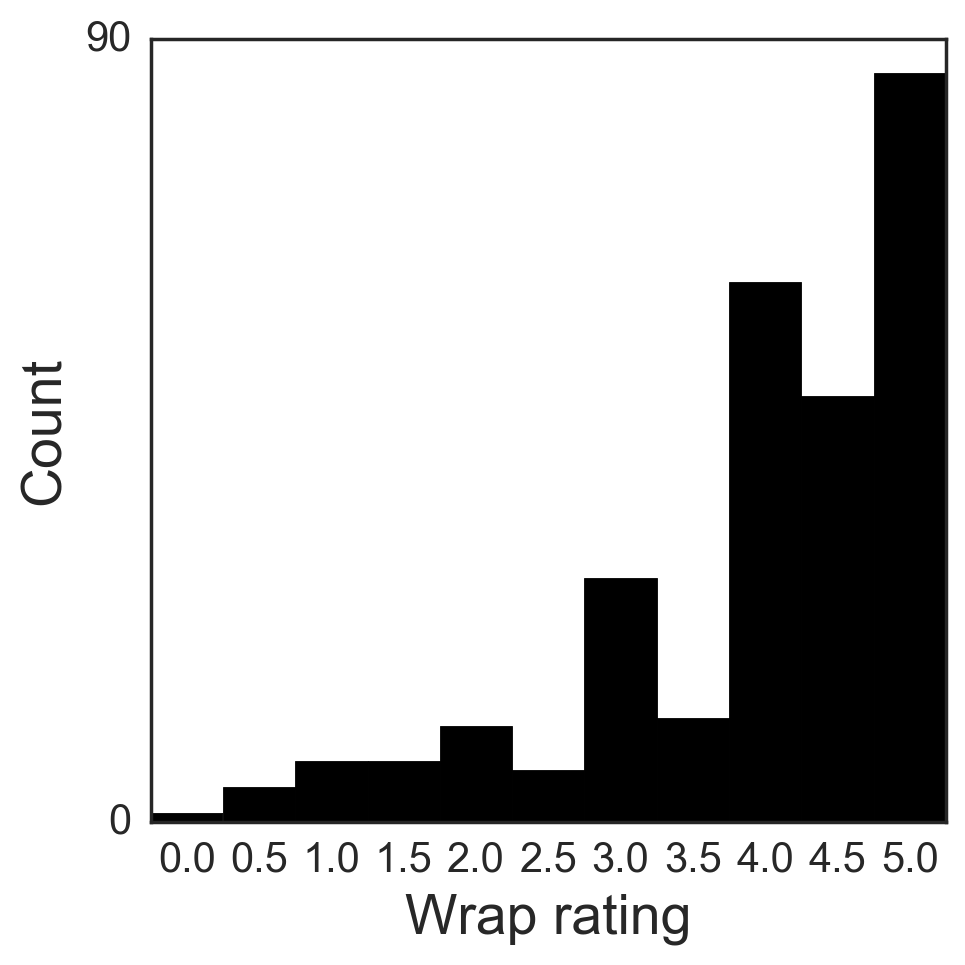

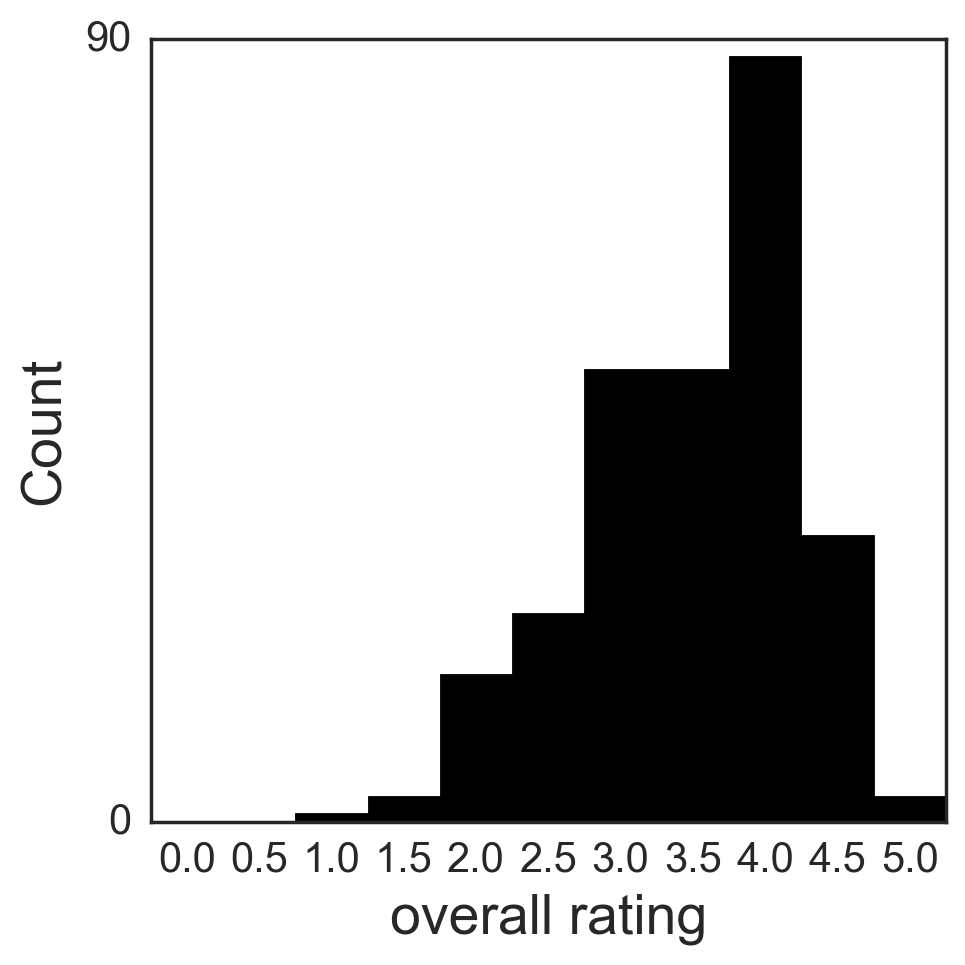

In [13]:
m_Hist = ['Tortilla','Temp','Meat','Fillings','Meat:filling','Uniformity','Salsa','Synergy','Wrap','overall']
for m in m_Hist:
    metrichist(m)

# Fraction of burritos recommended

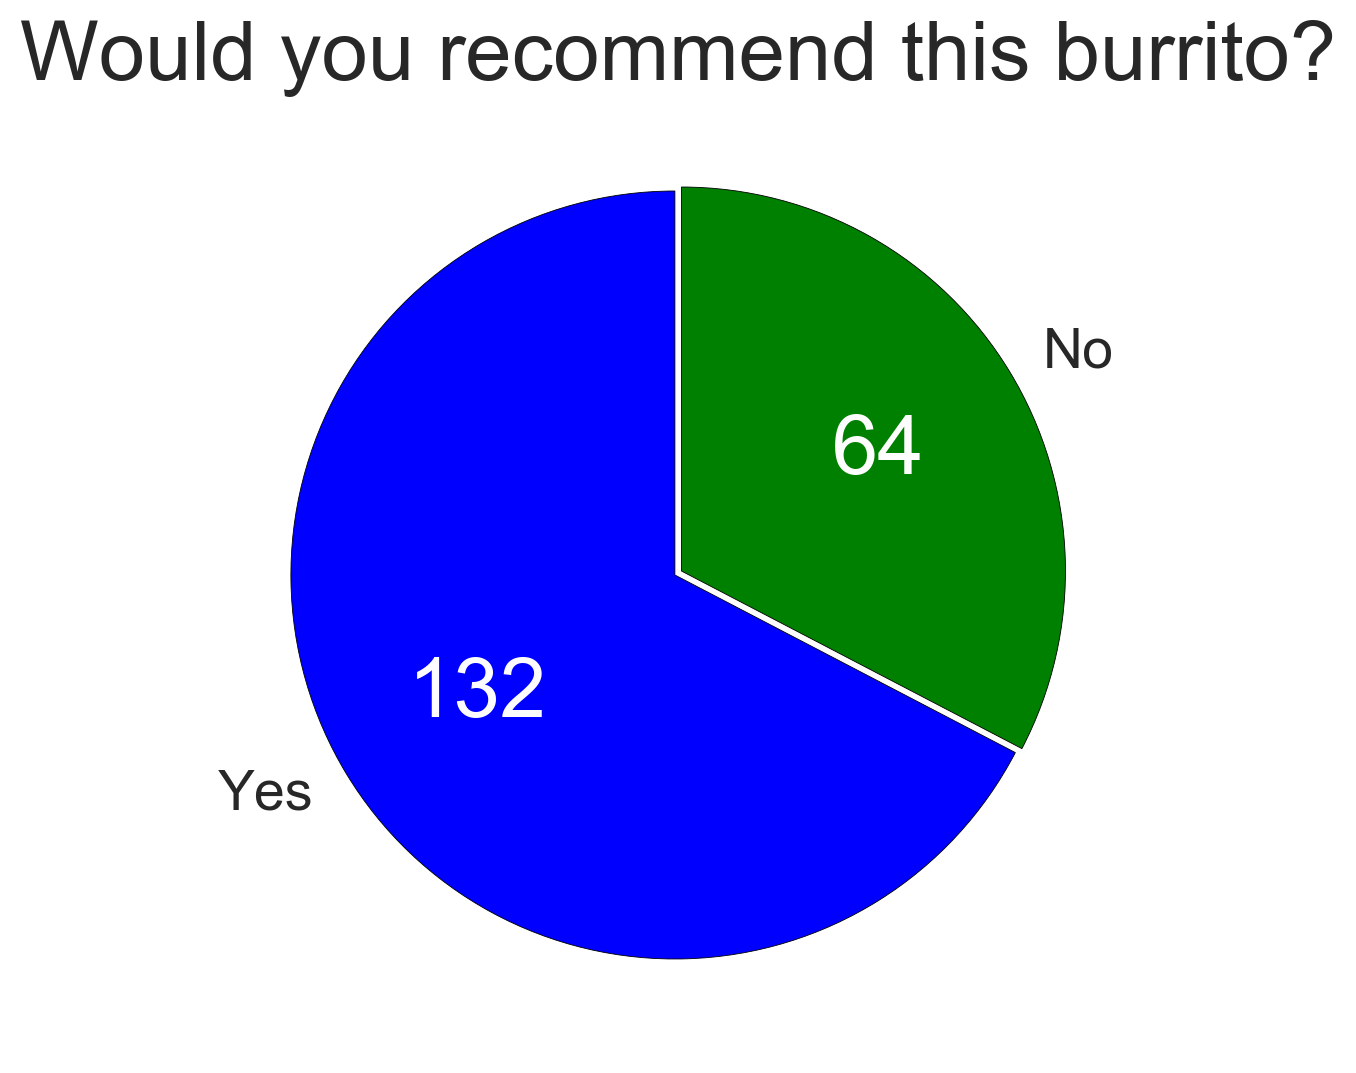

In [14]:
# Overall recommendations
plt.figure(figsize=(6,6))
ax = plt.axes([0.1, 0.1, 0.8, 0.8])

# The slices will be ordered and plotted counter-clockwise.
labels = ['Yes','No']
fracs = np.array([np.sum(df.Rec==labels[0]),np.sum(df.Rec==labels[1])])
explode=[.01]*len(labels)

patches, texts, autotexts = plt.pie(fracs, explode=explode, labels=labels,
                autopct=lambda(p): '{:.0f}'.format(p * np.sum(fracs) / 100), shadow=False, startangle=90)
                # The default startangle is 0, which would start
                # the Frogs slice on the x-axis.  With startangle=90,
                # everything is rotated counter-clockwise by 90 degrees,
                # so the plotting starts on the positive y-axis.

plt.title('Would you recommend this burrito?',size=30)
for t in texts:
    t.set_size(20)
for t in autotexts:
    t.set_size(30)
autotexts[0].set_color('w')
autotexts[1].set_color('w')

figname = 'recspie'
plt.savefig('C:/gh/fig/burrito/'+figname + '.png')

# PCA

In [15]:
dfpca = df[['Volume','Tortilla','Temp','Meat','Fillings','Meat:filling','Uniformity','Salsa','Synergy','Wrap']]

In [16]:
dfpca = dfpca.fillna(dfpca.mean())

In [17]:
# Normalize
dfpca = (dfpca - dfpca.mean()) / dfpca.std()
dfpca

,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap
0,-3.128830e-15,-0.551208,1.353044,-0.624998,0.049964,0.510848,0.576216,7.920860e-01,0.593408,0.034711
1,-3.128830e-15,-1.820210,-0.170125,-1.235250,-1.188969,-1.462354,0.576216,2.458919e-01,-1.108277,0.912123
2,-3.128830e-15,-0.551208,-1.693295,-1.235250,-0.569502,1.004149,0.576216,-3.003021e-01,-0.541048,0.912123
3,-3.128830e-15,-0.551208,-1.693295,-0.014746,-0.569502,0.510848,1.497217,7.920860e-01,0.593408,0.912123
4,-3.128830e-15,0.717793,1.353044,0.595506,0.049964,1.004149,1.497217,-8.464961e-01,1.160636,0.034711
5,-3.128830e-15,-0.551208,0.337598,1.816010,0.049964,-0.969054,-0.805286,-8.464961e-01,0.593408,-2.597525
6,-3.128830e-15,-1.820210,-0.677848,-0.624998,-1.808435,-0.969054,-0.805286,4.851177e-16,-1.675505,-0.842701
7,-3.128830e-15,-1.185709,-0.677848,-0.624998,-1.188969,-0.475753,0.115716,4.851177e-16,-1.108277,-0.842701
8,-3.128830e-15,-1.820210,0.845321,1.205758,0.049964,-1.955655,-0.344785,2.458919e-01,0.593408,-1.720113
9,-3.128830e-15,-1.185709,-2.201018,-2.455754,-0.569502,1.004149,-0.344785,-1.938884e+00,-1.675505,0.473417


In [18]:
# Color: Taco Stand, Lucha, Los Primos

In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(dfpca)
print pca.components_
print pca.explained_variance_ratio_

[[-0.04858711 -0.29944878 -0.18631254 -0.39368826 -0.41872519 -0.35614049
  -0.31040976 -0.30907931 -0.46012906 -0.11179043]
 [ 0.53771663 -0.05715817 -0.36783405  0.21736119  0.26563634 -0.25793521
  -0.28336658  0.08474212  0.1627076  -0.52345119]]
[ 0.31863152  0.13458633]


In [20]:
np.sum(pca.components_,1)

array([-2.89431091, -0.22158133])

In [21]:
dfpca_proj = np.dot(pca.components_,dfpca.T)

In [22]:
np.sum(df.Location=='taco stand')

21

In [23]:
foo = 'abc'
bar = 'ba'
zoo = '123'
foo == 'abc' and bar == 'bac' or zoo == '123'

True

In [24]:
dfpca_proj[0][np.where(df.Location=='taco stand')]

array([-0.80905101, -2.04470324, -1.3878547 , -0.98646158, -2.08394607,
       -0.51226074, -0.92113781, -0.71909228, -3.79761307, -1.16853765,
       -2.80511052, -0.40545384, -1.14112838, -2.21353452, -0.57663955,
       -1.09518187, -0.25078535, -0.98623928, -0.78001321, -3.37420903,
       -3.08487518])

In [25]:
shops[0] is 

SyntaxError: invalid syntax (<ipython-input-25-69c2e504f810>, line 1)

In [ ]:
np.sum(np.logical_or(notshops,df.Location==shops[2]))

In [ ]:
plt.plot(dfpca_proj[0],dfpca_proj[1],'k.')

In [ ]:
plt.figure(figsize=(8,8))
shops = ['taco stand','lucha libre north park','los primos mexican food']
shops_marker = ['*','^','s']
shops_ms = [20,12,12]
overallcutoffs = [-.1, 3, 4, 5.1]
overallcolors = ['r','k','g']


for o in range(len(overallcolors)):
    notshops = np.logical_and(df.Location != shops[0],np.logical_and(df.Location != shops[1],df.Location != shops[2]))
    orange = np.logical_and(df.overall>=overallcutoffs[o],df.overall<overallcutoffs[o+1])
    notshops = np.where(np.logical_and(notshops,orange))
    plt.plot(dfpca_proj[0][notshops],dfpca_proj[1][notshops],'.',color=overallcolors[o],alpha=.5,ms=20)
    for s in range(len(shops)):
        burridx = np.where(np.logical_and(df.Location==shops[s],np.logical_and(df.overall>=overallcutoffs[o],df.overall<overallcutoffs[o+1])))
        plt.plot(dfpca_proj[0][burridx],dfpca_proj[1][burridx],
                 shops_marker[s],color=overallcolors[o],ms=shops_ms[s],label = shops[s])
plt.xlim((-8,4.5))
plt.ylim((-3,4))
plt.xlabel('PC 1',size=20)
plt.ylabel('PC 2',size=20)
plt.xticks([])
plt.yticks([])
plt.legend(loc='best')

In [ ]:
shopsalpha = [.2,.2,.2]
shops = ['taco stand','lucha libre north park','los primos mexican food']
overall_marker = ['v','.','*']
overall_ms = [12,25,20]
overallcutoffs = [-.1, 3, 4, 5.1]
shopscolors = ['g','b','r']

plt.figure(figsize=(8,8))
for o in range(len(overallcolors)):
    notshops = np.logical_and(df.Location != shops[0],np.logical_and(df.Location != shops[1],df.Location != shops[2]))
    orange = np.logical_and(df.overall>=overallcutoffs[o],df.overall<overallcutoffs[o+1])
    notshops = np.where(np.logical_and(notshops,orange))[0]
    #plt.plot(df.Meat[notshops],df.Fillings[notshops],'.',color=overallcolors[o],alpha=.2,ms=20)
    for s in range(len(shops)):
        burridx = np.where(np.logical_and(df.Location==shops[s],np.logical_and(df.overall>=overallcutoffs[o],df.overall<overallcutoffs[o+1])))[0]
        plt.plot(df.Meat[burridx],df.Salsa[burridx],
                 overall_marker[o],color=shopscolors[s],ms=overall_ms[o],alpha=shopsalpha[s],label=shops[s])
plt.xlim((0,5.5))
plt.ylim((0,5.5))
plt.xlabel('Meat flavor',size=20)
plt.ylabel('Salsa flavor',size=20)
plt.xticks(np.arange(1,6),size=20)
plt.yticks(np.arange(1,6),size=20)
plt.legend(loc='best',fontsize=12)

plt.savefig('C:/gh/fig/burrito/superscatter.png')